# DengAI Analysis Part 03a - Feature Scaling and PCA

By: Chengyi (Jeff) Chen, under guidance of CSCI499: AI for Social Good Teaching Assistant - Aaron Ferber

---
## Content

In this notebook, we will apply some feature scaling and principle component analysis in order to reduce the number of features to only those that explain the most variance in  our data.

<a id="imports"></a>

---
## Library Imports

In [1]:
# Library Imports
import pandas as pd
import numpy as np
import subprocess
import statsmodels.formula.api as sm
from statsmodels import stats as sms
import statsmodels as statsmodels
from scipy import stats
import os
from collections import Counter
from sklearn import model_selection, kernel_ridge, linear_model, metrics, feature_selection, preprocessing
from os import listdir
from os.path import isfile, join, isdir
import warnings
warnings.filterwarnings('ignore')

# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns
sns.set(style="ticks")
from pylab import rcParams
%matplotlib inline

In [2]:
# DengAI dataset URLs
dengai_features_url = 'https://www.dropbox.com/s/1kuf94b4mk6axyy/dengue_features_train.csv'
dengai_labels_url = 'https://www.dropbox.com/s/626ak8397abonv4/dengue_labels_train.csv'
dengai_test_features_url = 'https://s3.amazonaws.com:443/drivendata/data/44/public/dengue_features_test.csv'

In [3]:
# Helper function to create a new folder
def mkdir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
        else:
            print("(%s) already exists" % (path))

<a id="clean_feats"></a>

---
## Cleaned Features

In [4]:
sj_X = pd.read_csv('./data/dengai/cleaned/sj_X.csv', index_col='week_start_date')
sj_y = pd.read_csv('./data/dengai/cleaned/sj_y.csv', header=None, names=['week_start_date', 'num_cases'], index_col='week_start_date')
iq_X = pd.read_csv('./data/dengai/cleaned/iq_X.csv', index_col='week_start_date')
iq_y = pd.read_csv('./data/dengai/cleaned/iq_y.csv', header=None, names=['week_start_date', 'num_cases'], index_col='week_start_date')

<a id="power_transform"></a>

---
## Yeo-Johnson Transform the Labels

In [5]:
from sklearn.preprocessing import PowerTransformer

# Applying yeo-johnson transform on the labels of City sj 
# REMEMBER TO INVERSE TRANSFORM YOUR Y_PREDS
sj_pwr = PowerTransformer()
sj_y = pd.Series(sj_pwr.fit_transform(sj_y).flatten(), index=sj_y.index)

# Applying yeo-johnson transform on the labels of City iq 
# REMEMBER TO INVERSE TRANSFORM YOUR Y_PREDS
iq_pwr = PowerTransformer()
iq_y = pd.Series(iq_pwr.fit_transform(iq_y).flatten(), index=iq_y.index)

---
<a id="feateng"></a>

## Feature Engineering / Scaling

__Now that we have checked each raw feature for any violation of linear regression assumptions, let's feature engineer to perform [transformations](https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/) to create new synthetic features that might help our models perform better.__

### 1. Power Transform (Make features normally distributed) / Log Transform (Reduce skewness)

__Yeo-Johnson Transform / Quantile Transform:__

In [6]:
from sklearn.preprocessing import power_transform

# Helper function to plot the power transformed
# versions of the features
def plot_pwr_dist(X):
    rcParams['figure.figsize'] = 20, 60
    fig, ax = plt.subplots(len(X.columns[2:]) // 2,2)

    for idx, name in enumerate(X.columns[2:]):
        if idx < len(X.columns[2:]) // 2:
            sns.distplot(X[name], ax=ax[idx, 0])
            sns.kdeplot(np.random.normal(size=len(X[name])), ax=ax[idx, 0])
            ax[idx, 0].grid(True)
            ax[idx, 0].set_title("Distribution of Yeo-Johnson Transformed {}".format(name), color='k')
        else:
            sns.distplot(X[name], ax=ax[idx - (len(X.columns[2:]) // 2), 1])
            sns.kdeplot(np.random.normal(size=len(X[name])), ax=ax[idx - (len(X.columns[2:]) // 2), 1])
            ax[idx - (len(X.columns[2:]) // 2), 1].grid(True)
            ax[idx - (len(X.columns[2:]) // 2), 1].set_title("Distribution of Yeo-Johnson Transformed  {}".format(name), color='k')

    plt.tight_layout()
    plt.show();

- __City sj:__

In [7]:
# Applying yeo-johnson transform on the features of City sj 
sj_X = pd.DataFrame(power_transform(sj_X, method='yeo-johnson'), index=sj_X.index, columns=sj_X.columns)

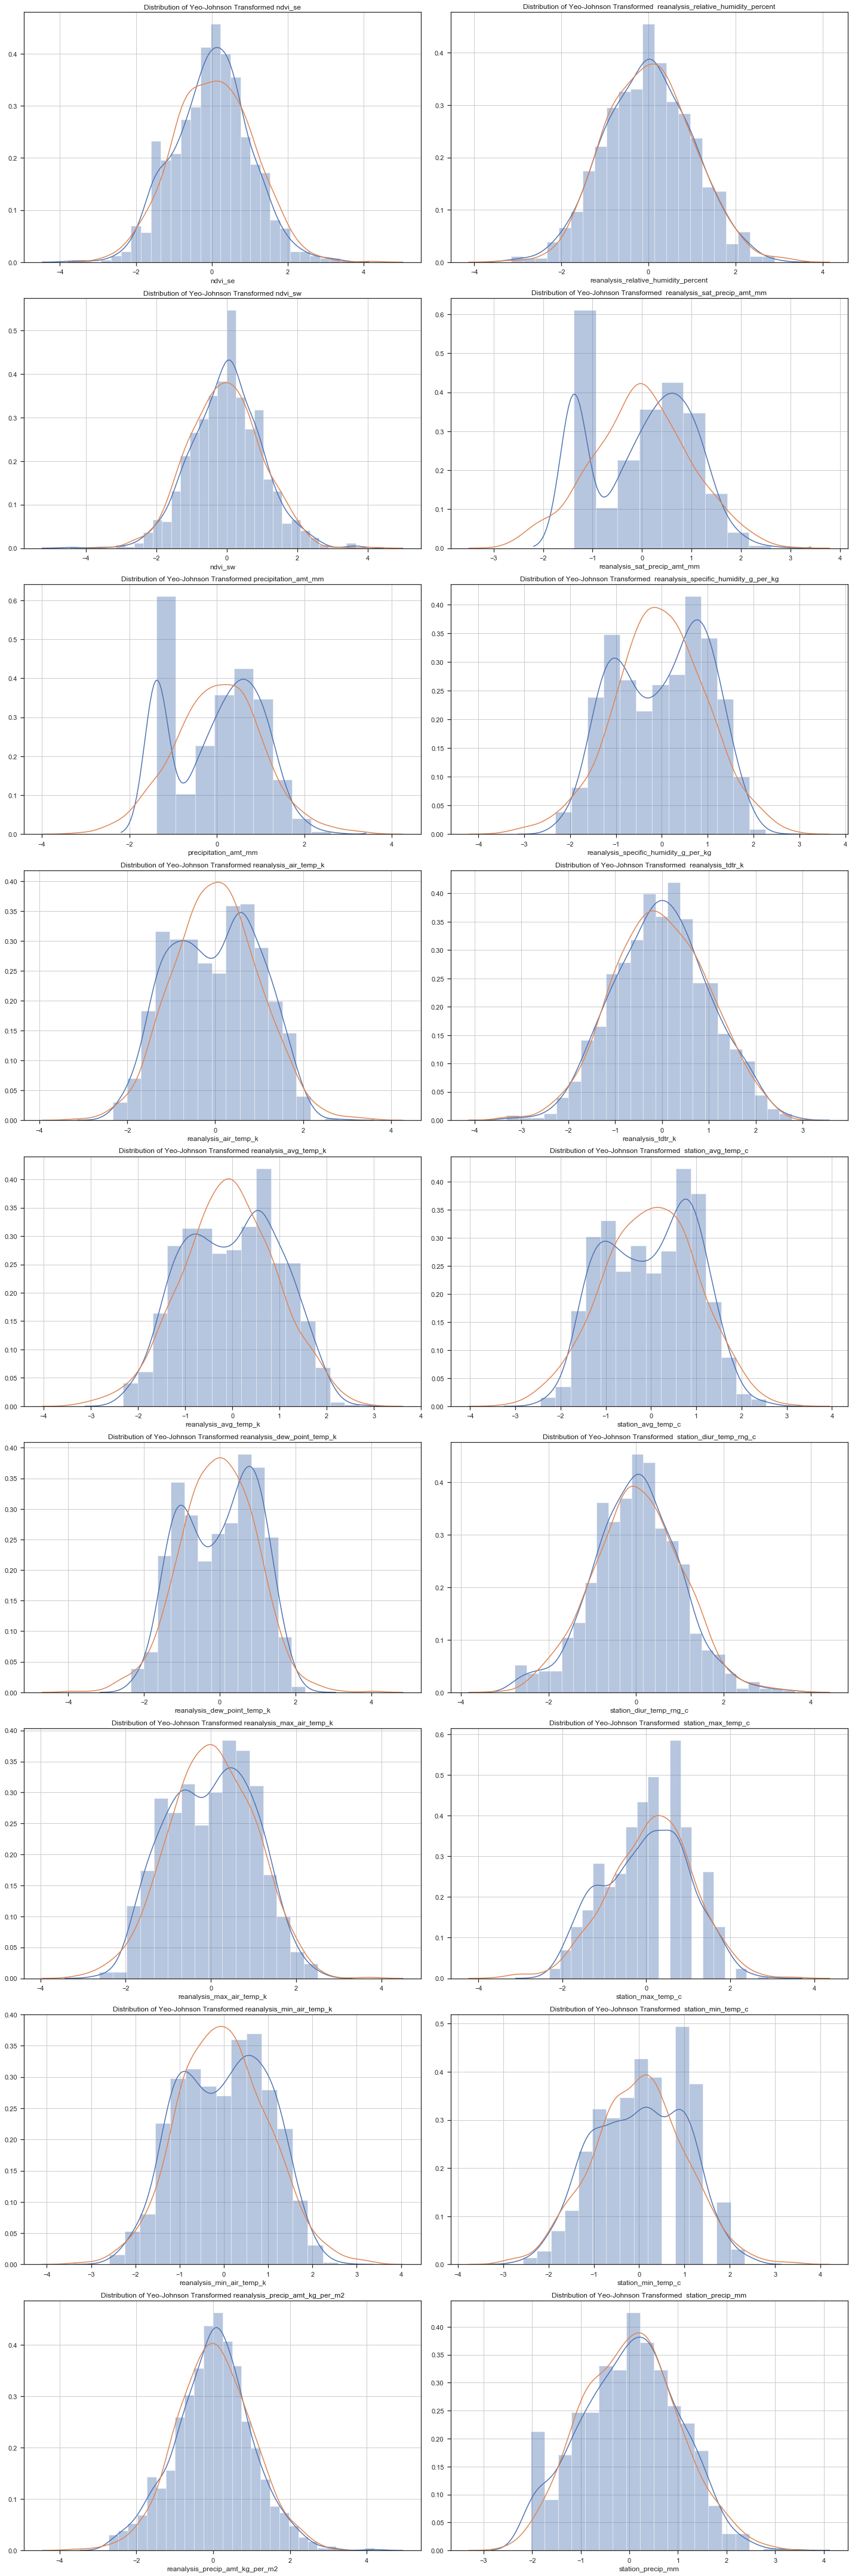

In [8]:
plot_pwr_dist(sj_X)

- __City iq:__

In [9]:
# Applying yeo-johnson transform on the features of City iq 
iq_X = pd.DataFrame(power_transform(iq_X, method='yeo-johnson'), index=iq_X.index, columns=iq_X.columns)

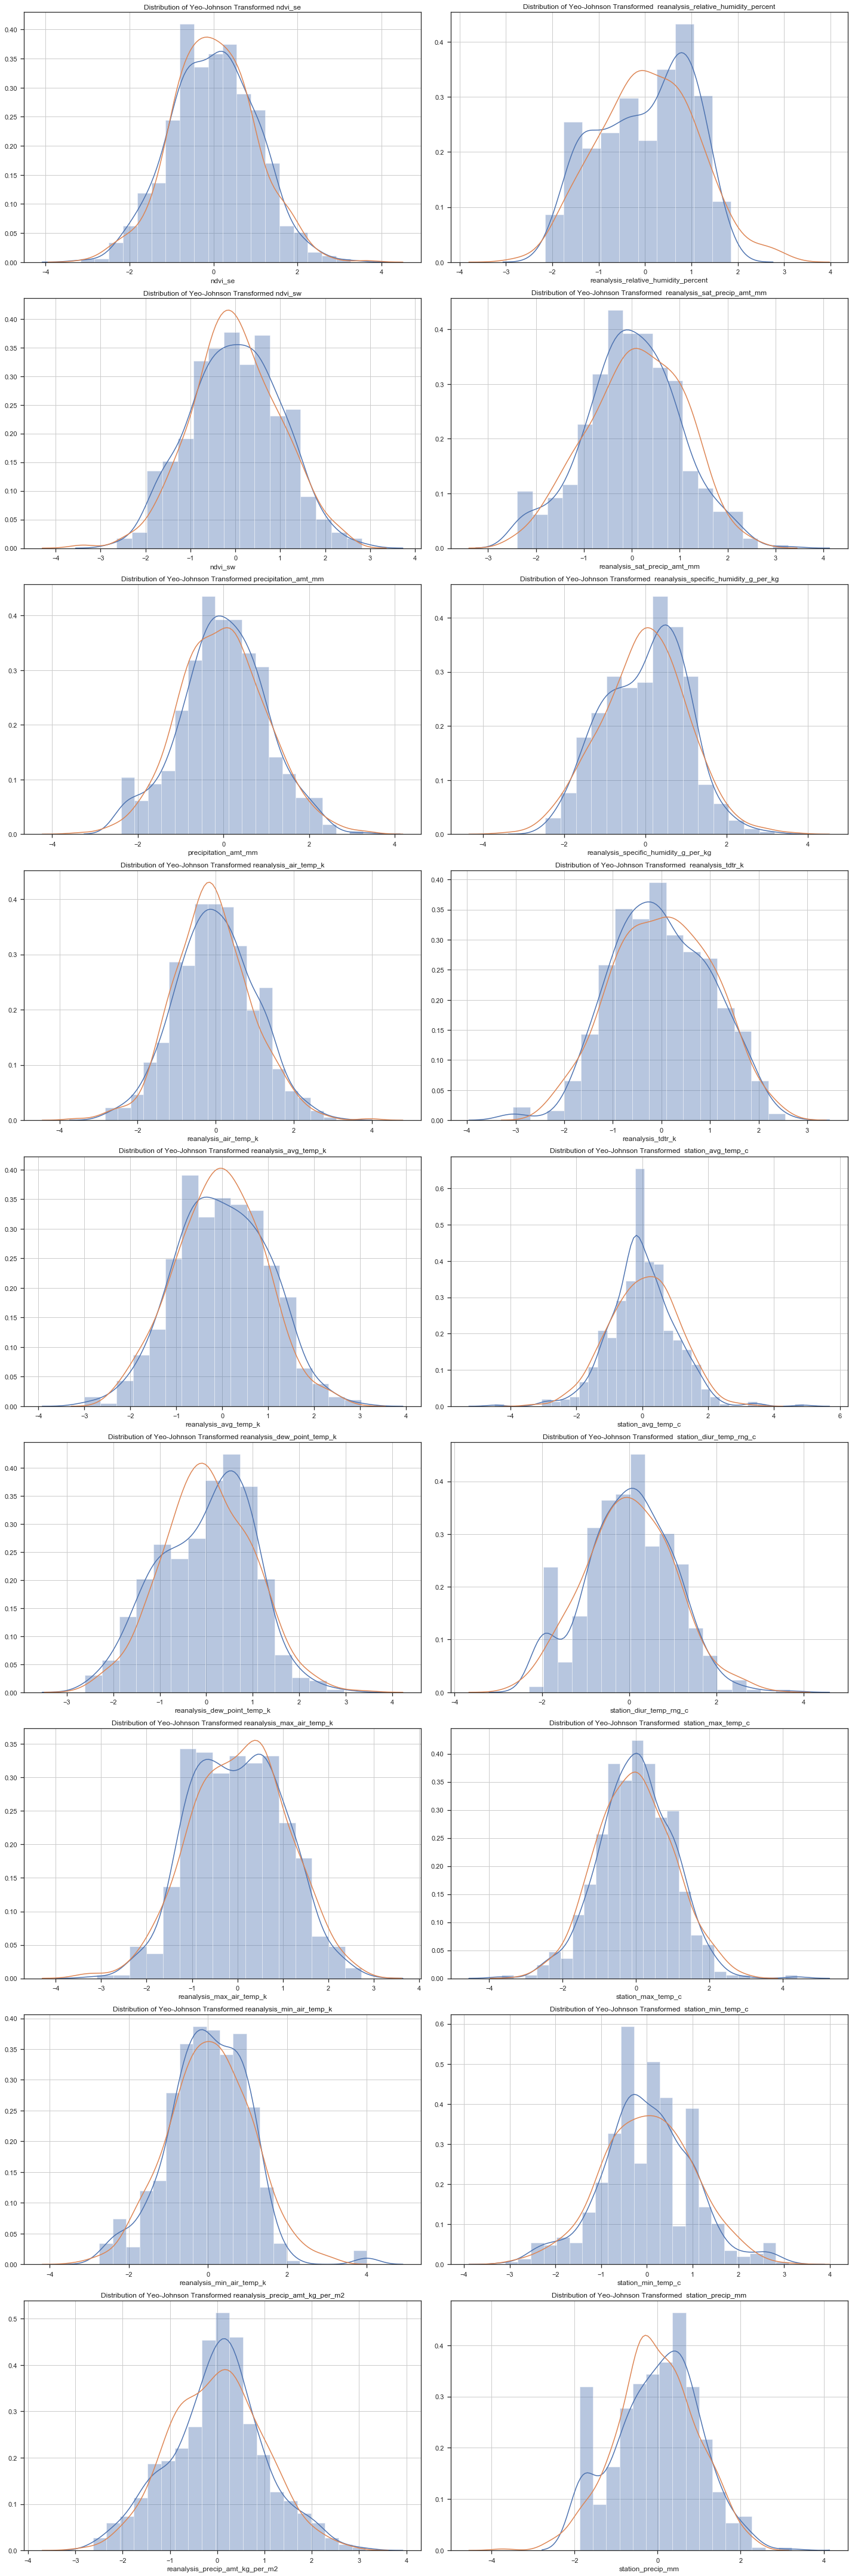

In [10]:
plot_pwr_dist(iq_X)

---
<a id="featselect"></a>

## Feature Selection

__Before continuing to normalize and then standardize our data, let's squash our features to a lower dimensional space. This could be done using either Principal Component Analysis (PCA) or Linear Discriminant Analysis (LDA), but here we will use PCA.__

### Principal Component Analysis

In [11]:
# We will perform PCA here using the original features,
# not the new feature set after removing features for
# multicollinearity using VIF
from sklearn import decomposition

sj_pca = decomposition.PCA(n_components='mle')

# PCA on City sj features
sj_X_pca = sj_pca.fit_transform(sj_X)

iq_pca = decomposition.PCA(n_components='mle')

# PCA on City iq features
iq_X_pca = iq_pca.fit_transform(iq_X)

In [12]:
print("City sj features shape BEFORE: {}, after: {}".format(sj_X.shape, sj_X_pca.shape))
print("City sj target shape:", sj_y.shape)

print("City iq features shape BEFORE: {}, after: {}".format(iq_X.shape, iq_X_pca.shape))
print("City iq target shape:", iq_y.shape)

City sj features shape BEFORE: (936, 20), after: (936, 19)
City sj target shape: (936,)
City iq features shape BEFORE: (520, 20), after: (520, 19)
City iq target shape: (520,)


### 4. Standardization

In [13]:
# Import standard scaler module
from sklearn.preprocessing import StandardScaler

# Scale City sj features
sj_X_pca = StandardScaler().fit_transform(sj_X_pca)

# Scale City iq features
iq_X_pca = StandardScaler().fit_transform(iq_X_pca)

### 5. Normalization

In [14]:
# Import minmax scaler module
from sklearn.preprocessing import MinMaxScaler

# Scale City sj features
sj_X_pca = MinMaxScaler().fit_transform(sj_X_pca)

# Scale City iq features
iq_X_pca = MinMaxScaler().fit_transform(iq_X_pca)

---

## Training with Transformed Features
__Now let's start training all the previous models we used in Part 2 with the transformed features__

In [15]:
# Import models and utilities from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from collections import defaultdict
from time import time

# Let's define a function that'll settle the training
# testing pipeline for us
def train(X, y, mods, pwr):
    """
    Handles the entire train and testing pipeline
    
    Parameters:
    -----------
    X: (pandas.DataFrame) Feature columns
    y: (pandas.DataFrame) Labels
    mods: (list) List of sklearn models to be trained on
    pwr: yeo-johnson Transformer that was used to transform y
    
    Returns:
    --------
    DataFrame of results of training and also a dictionary of the trained models
    """
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Initialize models dictionary
    trained_mods = {str(mod())[:str(mod()).find('(')]: mod for mod in mods}
    
    # Initialize model performance dictionary
    performance_mods = {str(mod())[:str(mod()).find('(')]: defaultdict(float) for mod in mods}
    
    # Split into training and testing sets using KFold cross validation
    kf = KFold(n_splits=20, shuffle=True, random_state=42)
    
    # Loop through all models
    for idx, (mod_name, mod) in enumerate(trained_mods.items()):
        
        # List of each score we get from each fold training / testing
        mse_train_scores = []
        mae_train_scores = []
        r2_train_scores = []
        mse_test_scores = []
        mae_test_scores = []
        r2_test_scores = []
        
        # Go through each fold in the KFold cross validation
        for train_index, test_index in kf.split(X):
            
            # Train Test Splits
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            ################
            ### TRAINING ###
            ################
            # Initialize current model
            curr_mod = mod()

            # Fit the model
            trained_mod = curr_mod.fit(X_train, y_train) 
            
            # Prediction scores for training set
            y_train_pred = pwr.inverse_transform(trained_mod.predict(X_train)[:,None]).astype(int)
            mse_train_scores.append(mean_squared_error(y_train, y_train_pred))
            mae_train_scores.append(mean_absolute_error(y_train, y_train_pred))
            r2_train_scores.append(r2_score(y_train, y_train_pred)) 
        
            ###############
            ### TESTING ###
            ###############
            # Prediction scores for testing set
            y_test_pred = pwr.inverse_transform(trained_mod.predict(X_test)[:,None]).astype(int)
            mse_test_scores.append(mean_squared_error(y_test, y_test_pred))
            mae_test_scores.append(mean_absolute_error(y_test, y_test_pred))
            r2_test_scores.append(r2_score(y_test, y_test_pred)) 
        
        # Saving average train scores
        performance_mods[mod_name]['train_' + str(mean_squared_error.__name__)] = np.mean(mse_train_scores)
        performance_mods[mod_name]['train_' + str(mean_absolute_error.__name__)] = np.mean(mae_train_scores)
        performance_mods[mod_name]['train_' + str(r2_score.__name__)] = np.mean(r2_train_scores)
        
        # Saving average test scores
        performance_mods[mod_name]['test_' + str(mean_squared_error.__name__)] = np.mean(mse_test_scores)
        performance_mods[mod_name]['test_' + str(mean_absolute_error.__name__)] = np.mean(mae_test_scores)
        performance_mods[mod_name]['test_' + str(r2_score.__name__)] = np.mean(r2_test_scores)
        
        # Saving last trained model
        trained_mods[mod_name] = trained_mod
            
    return performance_mods, trained_mods

In [16]:
# Let's declare the list of models we want to train
mods_to_train = [LinearRegression, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, KernelRidge, SVR, MLPRegressor]

In [17]:
# City SJ
sj_performance_mods, sj_trained_mods = train(sj_X_pca, sj_y, mods_to_train, sj_pwr)
pd.DataFrame.from_dict(sj_performance_mods).transpose()

,test_mean_absolute_error,test_mean_squared_error,test_r2_score,train_mean_absolute_error,train_mean_squared_error,train_r2_score
LinearRegression,20.802104,625.459136,-707.327214,20.693475,591.693931,-590.705188
RandomForestRegressor,20.863714,611.592217,-658.647555,25.869167,1490.103069,-1489.065849
AdaBoostRegressor,19.460106,461.513806,-502.612898,20.265953,537.542336,-536.433909
GradientBoostingRegressor,20.960036,607.202205,-672.853162,23.048432,985.742846,-984.483282
KernelRidge,20.448658,563.669986,-631.105053,20.378420,544.614703,-543.654001
SVR,19.730041,431.447698,-471.867880,19.761971,432.939359,-432.034236
MLPRegressor,20.940147,574.263480,-629.449491,21.004274,578.766490,-577.638275


In [18]:
# City IQ
iq_performance_mods, iq_trained_mods = train(iq_X_pca, iq_y, mods_to_train, iq_pwr)
pd.DataFrame.from_dict(iq_performance_mods).transpose()

,test_mean_absolute_error,test_mean_squared_error,test_r2_score,train_mean_absolute_error,train_mean_squared_error,train_r2_score
LinearRegression,3.895078,21.492971,-24.516741,3.879780,20.596638,-19.604277
RandomForestRegressor,3.908228,22.038990,-23.935008,5.045344,47.872454,-46.872125
AdaBoostRegressor,3.361172,14.843435,-15.559265,3.534919,16.384533,-15.385328
GradientBoostingRegressor,4.042884,23.139574,-25.879153,4.510628,30.648282,-29.660051
KernelRidge,3.781409,19.549007,-21.578991,3.755315,18.416914,-17.423306
SVR,4.051668,18.681725,-20.478814,4.047834,18.481174,-17.489123
MLPRegressor,3.983815,22.036496,-24.301205,3.962825,20.259356,-19.269793


__Seems like AdaBoost is still performing the best overall, so let's use that on the competition test features and use the AdaBoost predictions as our next submission.__

<a id="test"></a>

---
## Competition Test Prediction

__Here we will use the AdaBoost model in order to predict the labels given the competition's test features__

In [19]:
test_feats_df = pd.read_csv('./data/dengai/test_features/dengue_features_test.csv', index_col='week_start_date')
test_feats_df.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,sj,2008,18,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
2008-05-06,sj,2008,19,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2008-05-13,sj,2008,20,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
2008-05-20,sj,2008,21,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
2008-05-27,sj,2008,22,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


### Clean Data Pipeline

In [20]:
# Taking care of missing data
test_feats_df.fillna(test_feats_df.mode().iloc[0], inplace=True)

# Drop unecessary feature columns
test_feats_df = test_feats_df.drop(['year', 'weekofyear'], axis=1)

# Split dataset to City sj and City iq
test_sj_X = test_feats_df[test_feats_df['city'] == 'sj'].drop(['city'], axis=1)
test_sj_X.index = pd.to_datetime(test_sj_X.index)

test_iq_X = test_feats_df[test_feats_df['city'] == 'iq'].drop(['city'], axis=1)
test_iq_X.index = pd.to_datetime(test_iq_X.index)

### Feature Transformations

In [21]:
def transform_feats(X):
    """
    Transforms the features and returns the transformed numpy array
    
    Parameters:
    -----------
    X: (numpy.array) Feature columns that need to be transformed
    
    Returns:
    --------
    A numpy array with transformed features
    """
    # Transform features to be more normal
    X = power_transform(X, method='yeo-johnson')
    
    # Apply PCA
    X_pca = decomposition.PCA(n_components='mle').fit_transform(X)
    
    # Standardize
    X_scaled = StandardScaler().fit_transform(X_pca)
    
    # Normalize
    X_scaled = MinMaxScaler().fit_transform(X_pca)
    
    return X_scaled

### Prediction

In [22]:
test_sj_y_pred = sj_pwr.inverse_transform(sj_trained_mods['AdaBoostRegressor'].predict(transform_feats(test_sj_X))[:,None])
test_iq_y_pred = iq_pwr.inverse_transform(iq_trained_mods['AdaBoostRegressor'].predict(transform_feats(test_iq_X))[:,None])

In [23]:
# Save the results to csv and upload to competition
submission_df = pd.read_csv('./data/dengai/submission_format.csv')
submission_df.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,0
1,sj,2008,19,0
2,sj,2008,20,0
3,sj,2008,21,0
4,sj,2008,22,0


In [24]:
sj_submission_df = submission_df[submission_df['city'] == 'sj'].drop(['total_cases'], axis=1)
sj_submission_df.reset_index(inplace=True)
sj_submission_df = pd.concat([sj_submission_df, pd.DataFrame(test_sj_y_pred.flatten().astype(int), columns=['total_cases'])], axis=1)
sj_submission_df.index = sj_submission_df['index']
sj_submission_df.drop(['index'], axis=1, inplace=True)
sj_submission_df.head()

,city,year,weekofyear,total_cases
index,,,,
0,sj,2008,18,21
1,sj,2008,19,17
2,sj,2008,20,11
3,sj,2008,21,18
4,sj,2008,22,21


In [25]:
iq_submission_df = submission_df[submission_df['city'] == 'iq'].drop(['total_cases'], axis=1)
iq_submission_df.reset_index(inplace=True)
iq_submission_df = pd.concat([iq_submission_df, pd.DataFrame(test_iq_y_pred.flatten().astype(int), columns=['total_cases'])], axis=1)
iq_submission_df.index = iq_submission_df['index']
iq_submission_df.drop(['index'], axis=1, inplace=True)
iq_submission_df.head()

,city,year,weekofyear,total_cases
index,,,,
260,iq,2010,26,6
261,iq,2010,27,2
262,iq,2010,28,5
263,iq,2010,29,4
264,iq,2010,30,2


In [26]:
submission_df = pd.concat([sj_submission_df, iq_submission_df], axis=0).reset_index().drop(['index'], axis=1)
submission_df.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,21
1,sj,2008,19,17
2,sj,2008,20,11
3,sj,2008,21,18
4,sj,2008,22,21


In [27]:
# Save to csv
submission_df.to_csv('./data/dengai/adaboost_submission.csv', index=False)

__This received an MAE score of 28.8966 in the competition, which is better than the vanilla adaboost and untransformed features, but still pretty bad...__